## Problem: With the new Pokemon games that came out in November 2022, I want to find out which new pokemon would do the best competitively

To run this program we need beautifulsoup4 and requests. If you don't have them installed please do it now

In [1]:
pip install beautifulsoup4


Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)'))) - skipping


In [2]:
pip install requests

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
%matplotlib inline

We need to scrape relevent pokemon data. This means, every pokemon along with their stats, types, and move sets

In [4]:
#pulling the data
url = "https://pokemondb.net/pokedex/stats/combo"
proxies = {'https': 'http://127.0.0.1:7769'} #I need on my computer but you might not need on yours
res = requests.get(url, proxies=proxies)

In [5]:
res

<Response [200]>

In [6]:
doc = BeautifulSoup(res.text, "html.parser")
#print(doc.prettify())

In [7]:
html_pokedex = doc.find_all('table', attrs={'class': 'data-table sticky-header'})

In [8]:
names = doc.find_all('a', attrs={'class': 'ent-name'})
len(names)

1190

In [9]:
poke_types_proto = doc.find_all('td', attrs={'class': 'cell-icon'})
len(poke_types_proto)

1190

In [10]:
poke_types1 = []
for i in poke_types_proto:
    poke_types1.append(i.find_all('a', attrs={'class': 'type-icon'}))
len(poke_types1)

1190

In [11]:
df = pd.DataFrame()
df['names'] = names
df['poke_types1'] = poke_types1
df.head()

,names,poke_types1
0,[Bulbasaur],"[[Grass], [Poison]]"
1,[Ivysaur],"[[Grass], [Poison]]"
2,[Venusaur],"[[Grass], [Poison]]"
3,[Venusaur],"[[Grass], [Poison]]"
4,[Charmander],[[Fire]]


In [12]:
df['poke_types2'] = 0
for i in range(len(poke_types1)):
    if len(df['poke_types1'][i]) == 2:
        df['poke_types2'][i] = df['poke_types1'][i][1].text
df.head()

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/471602070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poke_types2'][i] = df['poke_types1'][i][1].text
C:\Users\matth\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,names,poke_types1,poke_types2
0,[Bulbasaur],"[[Grass], [Poison]]",Poison
1,[Ivysaur],"[[Grass], [Poison]]",Poison
2,[Venusaur],"[[Grass], [Poison]]",Poison
3,[Venusaur],"[[Grass], [Poison]]",Poison
4,[Charmander],[[Fire]],0


In [13]:
df['names'] = df['names'].map(lambda x: x.text)
df['poke_types1'] = df['poke_types1'].map(lambda x: x[0].text )
df.head()

,names,poke_types1,poke_types2
0,Bulbasaur,Grass,Poison
1,Ivysaur,Grass,Poison
2,Venusaur,Grass,Poison
3,Venusaur,Grass,Poison
4,Charmander,Fire,0


In [14]:
stats = doc.find_all('td', attrs={'class': 'cell-num'})
len(stats)

8330

In [15]:
len(stats)/7

1190.0

In [16]:
physical_sweeper = []
special_sweeper = []
wall = []
physical_tank = []
special_tank = []
total = []
for i in range(len(stats)):
    if i % 7 == 1:
        physical_sweeper.append(stats[i].text)
    if i % 7 == 2:
        special_sweeper.append(stats[i].text)
    if i % 7 == 3:
        wall.append(stats[i].text)
    if i % 7 == 4:
        physical_tank.append(stats[i].text)
    if i % 7 == 5:
        special_tank.append(stats[i].text)
    if i % 7 == 6:
        total.append(stats[i].text)

In [17]:
df["physical_sweeper"] = physical_sweeper
df["special_sweeper"] = special_sweeper
df["wall"] = wall
df["physical_tank"] = physical_tank
df["special_tank"] = special_tank
df["total"] = total
df.head()

,names,poke_types1,poke_types2,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total
0,Bulbasaur,Grass,Poison,94,110,159,98,130,318
1,Ivysaur,Grass,Poison,122,140,203,125,160,405
2,Venusaur,Grass,Poison,162,180,263,165,200,525
3,Venusaur,Grass,Poison,180,202,323,223,242,625
4,Charmander,Fire,0,117,125,132,95,110,309


We need to condense the poketypes into one column. We also need to make, for example, grass poison type pokemon the same as poison grass types

In [18]:
def combo_types(type1, type2):
    output = []
    if type2 == 0:
        output.append(type1)
    else:
        output.append(type1)
        output.append(type2)
        output = sorted(output)
    return output

In [19]:
df['poke_types'] = 0
for i in range(len(df)):
    df['poke_types'][i] = combo_types(df['poke_types1'][i], df['poke_types2'][i])

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/1818310906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poke_types'][i] = combo_types(df['poke_types1'][i], df['poke_types2'][i])
C:\Users\matth\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
df.head()

,names,poke_types1,poke_types2,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types
0,Bulbasaur,Grass,Poison,94,110,159,98,130,318,"[Grass, Poison]"
1,Ivysaur,Grass,Poison,122,140,203,125,160,405,"[Grass, Poison]"
2,Venusaur,Grass,Poison,162,180,263,165,200,525,"[Grass, Poison]"
3,Venusaur,Grass,Poison,180,202,323,223,242,625,"[Grass, Poison]"
4,Charmander,Fire,0,117,125,132,95,110,309,[Fire]


In [21]:
#Let's check that it worked
df[df['names'] == 'Fearow']

,names,poke_types1,poke_types2,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types
29,Fearow,Normal,Flying,190,161,191,155,122,442,"[Flying, Normal]"


Looks like it worked. Let's remove poke_types1 and poke_types2

In [22]:
df.drop(['poke_types1', 'poke_types2'], inplace=True, axis=1)
df.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types
0,Bulbasaur,94,110,159,98,130,318,"[Grass, Poison]"
1,Ivysaur,122,140,203,125,160,405,"[Grass, Poison]"
2,Venusaur,162,180,263,165,200,525,"[Grass, Poison]"
3,Venusaur,180,202,323,223,242,625,"[Grass, Poison]"
4,Charmander,117,125,132,95,110,309,[Fire]


We see that there are multiple pokemon of the same name. That is because there are different forms and regional varients. Let us make a column that address that

In [23]:
form = doc.find_all('small', attrs={'class': 'text-muted'})
form

[<small class="text-muted">Mega Venusaur</small>,
 <small class="text-muted">Mega Charizard X</small>,
 <small class="text-muted">Mega Charizard Y</small>,
 <small class="text-muted">Mega Blastoise</small>,
 <small class="text-muted">Mega Beedrill</small>,
 <small class="text-muted">Mega Pidgeot</small>,
 <small class="text-muted">Alolan Rattata</small>,
 <small class="text-muted">Alolan Raticate</small>,
 <small class="text-muted">Partner Pikachu</small>,
 <small class="text-muted">Alolan Raichu</small>,
 <small class="text-muted">Alolan Sandshrew</small>,
 <small class="text-muted">Alolan Sandslash</small>,
 <small class="text-muted">Alolan Vulpix</small>,
 <small class="text-muted">Alolan Ninetales</small>,
 <small class="text-muted">Alolan Diglett</small>,
 <small class="text-muted">Alolan Dugtrio</small>,
 <small class="text-muted">Alolan Meowth</small>,
 <small class="text-muted">Galarian Meowth</small>,
 <small class="text-muted">Alolan Persian</small>,
 <small class="text-muted

In [24]:
len(form)

219

In [25]:
df['form'] = 'regular'
name_list = []
multi_name_list = []
c = 0
p = 0
for i in df['names']:
    if i in name_list:
        multi_name_list.append(i)
        df['form'][c] = form[p].text
        p = p + 1
    else:
        name_list.append(i)
    c = c + 1
multi_name_list

['Venusaur',
 'Charizard',
 'Charizard',
 'Blastoise',
 'Beedrill',
 'Pidgeot',
 'Rattata',
 'Raticate',
 'Pikachu',
 'Raichu',
 'Sandshrew',
 'Sandslash',
 'Vulpix',
 'Ninetales',
 'Diglett',
 'Dugtrio',
 'Meowth',
 'Meowth',
 'Persian',
 'Growlithe',
 'Arcanine',
 'Alakazam',
 'Geodude',
 'Graveler',
 'Golem',
 'Ponyta',
 'Rapidash',
 'Slowpoke',
 'Slowbro',
 'Slowbro',
 "Farfetch'd",
 'Grimer',
 'Muk',
 'Gengar',
 'Voltorb',
 'Electrode',
 'Exeggutor',
 'Marowak',
 'Weezing',
 'Kangaskhan',
 'Mr. Mime',
 'Pinsir',
 'Tauros',
 'Tauros',
 'Tauros',
 'Gyarados',
 'Eevee',
 'Aerodactyl',
 'Articuno',
 'Zapdos',
 'Moltres',
 'Mewtwo',
 'Mewtwo',
 'Typhlosion',
 'Ampharos',
 'Wooper',
 'Slowking',
 'Steelix',
 'Qwilfish',
 'Scizor',
 'Heracross',
 'Sneasel',
 'Corsola',
 'Houndoom',
 'Tyranitar',
 'Sceptile',
 'Blaziken',
 'Swampert',
 'Zigzagoon',
 'Linoone',
 'Gardevoir',
 'Sableye',
 'Mawile',
 'Aggron',
 'Medicham',
 'Manectric',
 'Sharpedo',
 'Camerupt',
 'Altaria',
 'Castform',
 'Ca

In [26]:
len(multi_name_list)

182

In [27]:
df.head(20)

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form
0,Bulbasaur,94,110,159,98,130,318,"[Grass, Poison]",regular
1,Ivysaur,122,140,203,125,160,405,"[Grass, Poison]",regular
2,Venusaur,162,180,263,165,200,525,"[Grass, Poison]",regular
3,Venusaur,180,202,323,223,242,625,"[Grass, Poison]",Mega Venusaur
4,Charmander,117,125,132,95,110,309,[Fire],regular
5,Charmeleon,144,160,181,122,145,405,[Fire],regular
6,Charizard,184,209,241,162,194,534,"[Fire, Flying]",regular
7,Charizard,230,230,274,241,215,634,"[Dragon, Fire]",Mega Charizard X
8,Charizard,204,259,271,182,274,634,"[Fire, Flying]",Mega Charizard Y
9,Squirtle,91,93,173,113,114,314,[Water],regular


I want to add as much data as I can from each pokemon. To do that we need to examine the entry for each pokemon's webpage. Let's first look at bulbasaur

In [28]:
#pulling the data
url2 = "https://pokemondb.net/pokedex/bulbasaur"
res2 = requests.get(url2, proxies=proxies)

In [29]:
doc2 = BeautifulSoup(res2.text, "html.parser")
#print(doc2.prettify())

In [30]:
move_set = doc2.find_all('a', attrs={'class': 'ent-name'})
move_set

[<a class="ent-name" href="/pokedex/bulbasaur">Bulbasaur</a>,
 <a class="ent-name" href="/pokedex/ivysaur">Ivysaur</a>,
 <a class="ent-name" href="/pokedex/venusaur">Venusaur</a>,
 <a class="ent-name" href="/move/growl" title="View details for Growl">Growl</a>,
 <a class="ent-name" href="/move/tackle" title="View details for Tackle">Tackle</a>,
 <a class="ent-name" href="/move/vine-whip" title="View details for Vine Whip">Vine Whip</a>,
 <a class="ent-name" href="/move/growth" title="View details for Growth">Growth</a>,
 <a class="ent-name" href="/move/leech-seed" title="View details for Leech Seed">Leech Seed</a>,
 <a class="ent-name" href="/move/razor-leaf" title="View details for Razor Leaf">Razor Leaf</a>,
 <a class="ent-name" href="/move/poison-powder" title="View details for Poison Powder">Poison Powder</a>,
 <a class="ent-name" href="/move/sleep-powder" title="View details for Sleep Powder">Sleep Powder</a>,
 <a class="ent-name" href="/move/seed-bomb" title="View details for See

In [31]:
len(move_set)

110

Let's remove the pokemon names and evolutionary lines

In [32]:
move_set2 = []
for i in move_set:
    if i.text not in name_list:
        move_set2.append(i.text)

In [33]:
len(move_set2)

107

Let's add a columns for each pokemon. It will give us the pokemon's moveset

In [34]:
def move_set(pokemon,proxies,name_list):
    poke_fixed = pokemon.replace(' ','-')
    url = "https://pokemondb.net/pokedex/" + poke_fixed
    res = requests.get(url, proxies=proxies)
    doc = BeautifulSoup(res.text, "html.parser")
    moves = doc.find_all('a', attrs={'class': 'ent-name'})
    for i in moves:
        if i.text in name_list:
            moves.pop(0)
        else:
            break
    return moves

In [35]:
df['move_set'] = 0
for i in range(len(df)):
    df['move_set'][i] = move_set(df['names'][i], proxies, name_list)
df.head()

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/1491604334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['move_set'][i] = move_set(df['names'][i], proxies, name_list)
C:\Users\matth\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set
0,Bulbasaur,94,110,159,98,130,318,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Tackle], [Vine Whip], [..."
1,Ivysaur,122,140,203,125,160,405,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Tackle], [Vin..."
2,Venusaur,162,180,263,165,200,525,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Petal Blizzar..."
3,Venusaur,180,202,323,223,242,625,"[Grass, Poison]",Mega Venusaur,"[[Venusaur], [Growl], [Growth], [Petal Blizzar..."
4,Charmander,117,125,132,95,110,309,[Fire],regular,"[[Charizard], [Growl], [Scratch], [Ember], [Sm..."


In [36]:
df[df['names'] == 'Tapu Koko']

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set
943,Tapu Koko,245,225,230,200,170,570,"[Electric, Fairy]",regular,"[[Quick Attack], [Thunder Shock], [Withdraw], ..."


The last column we need is our measurement. We need to find which pokemon have won a tournament and how many times. I am using this link https://www.vgcpedia.com/world-championships-hub/. It lists every winning and runner up team since 2010 (meaning 2010-2022). Because the list isn't long I will manually enter the data with 1 point for each time a pokemon was on the winning team in a tournament. 

In [37]:
poke_winners = {'Kyogre': 1, 'Groudon': 1, 'Dialga': 1, 'Ludicolo': 1, 'Hariyama': 1, 'Cresselia': 1,
                'Thundurus': 1, 'Terrakion': 1, 'Conkeldurr': 1, 'Hydreigon': 1, 'Gothitelle': 1, 'Escavalier': 1,
                'Tyranitar': 1, 'Metagross': 1, 'Garchomp': 1, 'Rotom': 1, 'Mamoswine': 1, 'Heatran': 1,
                'Amoonguss': 1, 'Latios': 1, 'Gyarados': 1, 'Pachirisu': 1, 'Talonflame': 1, 'Gardevoir': 1,
                'Kangaskhan': 1, 'Landorus': 1, 'Rayquaza': 1, 'Gengar': 1, 'Hitmontop': 1, 'Raichu': 1,
                'Bronzong': 1, 'Tapu Koko': 1, 'Tapu Fini': 1, 'Krookodile': 1, 'Marowak': 1, 'Whimsicott': 1,
                'Celesteela': 1, 'Salamence': 1, 'Incineroar': 1, 'Kartana': 1, 'Gastrodon': 1, 'Snorlax': 1,
                'Lunala': 1, 'Stakataka': 1, 'Zacian': 1, 'Calyrex': 1, 'Rillaboom': 1}

In [38]:
df['winners'] = df['names'].map(poke_winners)
df.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set,winners
0,Bulbasaur,94,110,159,98,130,318,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Tackle], [Vine Whip], [...",NaN
1,Ivysaur,122,140,203,125,160,405,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Tackle], [Vin...",NaN
2,Venusaur,162,180,263,165,200,525,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",NaN
3,Venusaur,180,202,323,223,242,625,"[Grass, Poison]",Mega Venusaur,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",NaN
4,Charmander,117,125,132,95,110,309,[Fire],regular,"[[Charizard], [Growl], [Scratch], [Ember], [Sm...",NaN


In [39]:
df['winners'] = df['winners'].map(lambda x: x if x > 0 else 0)
df.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set,winners
0,Bulbasaur,94,110,159,98,130,318,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Tackle], [Vine Whip], [...",0.0
1,Ivysaur,122,140,203,125,160,405,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Tackle], [Vin...",0.0
2,Venusaur,162,180,263,165,200,525,"[Grass, Poison]",regular,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",0.0
3,Venusaur,180,202,323,223,242,625,"[Grass, Poison]",Mega Venusaur,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",0.0
4,Charmander,117,125,132,95,110,309,[Fire],regular,"[[Charizard], [Growl], [Scratch], [Ember], [Sm...",0.0


In [40]:
df[df['winners'] > 0]

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set,winners
34,Raichu,200,200,195,145,170,485,[Electric],regular,"[[Raichu], [Raichu], [Agility], [Charm], [Disc...",1.0
35,Raichu,195,205,195,135,180,485,"[Electric, Psychic]",Alolan Raichu,"[[Raichu], [Raichu], [Agility], [Charm], [Disc...",1.0
126,Gengar,175,240,195,125,205,500,"[Ghost, Poison]",regular,"[[Gengar], [Confuse Ray], [Hypnosis], [Lick], ...",1.0
127,Gengar,195,300,235,145,265,600,"[Ghost, Poison]",Mega Gengar,"[[Gengar], [Confuse Ray], [Hypnosis], [Lick], ...",1.0
141,Marowak,125,95,250,190,130,425,[Ground],regular,"[[Marowak], [False Swipe], [Growl], [Mud-Slap]...",1.0
...,...,...,...,...,...,...,...,...,...,...,...
1053,Zacian,258,218,322,235,195,660,[Fairy],regular,"[[Bite], [Howl], [Metal Claw], [Quick Attack],...",1.0
1054,Zacian,298,228,322,265,195,700,"[Fairy, Steel]",Hoopa Confined,"[[Bite], [Howl], [Metal Claw], [Quick Attack],...",1.0
1067,Calyrex,160,160,260,160,160,500,"[Grass, Psychic]",regular,"[[Confusion], [Growth], [Mega Drain], [Pound],...",1.0
1068,Calyrex,215,135,380,315,215,680,"[Ice, Psychic]",Pom-Pom Style,"[[Confusion], [Growth], [Mega Drain], [Pound],...",1.0


Now we have to delete any row that has mythical pokemon as they are not allowed in tournaments 

In [41]:
mythical = ['Mew', 'Celebi', 'Jirachi', 'Deoxys', 'Phione', 'Manaphy', 'Darkrai', 'Shaymin', 'Arceus',
            'Victini', 'Keldeo', 'Meloetta', 'Genesect', 'Diancie', 'Hoopa', 'Volcanion', 'Magearna',
            'Marshadow', 'Zeraora', 'Meltan', 'Melmetal', 'Zarude']

In [42]:
for i in mythical:
    df.drop(df.index[df['names'] == i], inplace=True)
len(df)

1160

Now that the data is imported and cleaned it is time for the analysis and modelling

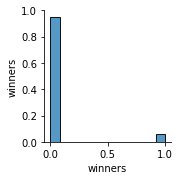

In [43]:
sns.pairplot(df);

something went wrong. Let us check the value types of each column

df.dropna(inplace = True)
df.dtypes

We need more numerical values

In [44]:
df['physical_sweeper'] = df['physical_sweeper'].map(lambda x: float(x))
df['special_sweeper'] = df['special_sweeper'].map(lambda x: float(x))
df['wall'] = df['wall'].map(lambda x: float(x))
df['physical_tank'] = df['physical_tank'].map(lambda x: float(x))
df['special_tank'] = df['special_tank'].map(lambda x: float(x))
df['total'] = df['total'].map(lambda x: float(x))
df.dtypes

names                object
physical_sweeper    float64
special_sweeper     float64
wall                float64
physical_tank       float64
special_tank        float64
total               float64
poke_types           object
form                 object
move_set             object
winners             float64
dtype: object

Let's continue with the analysis

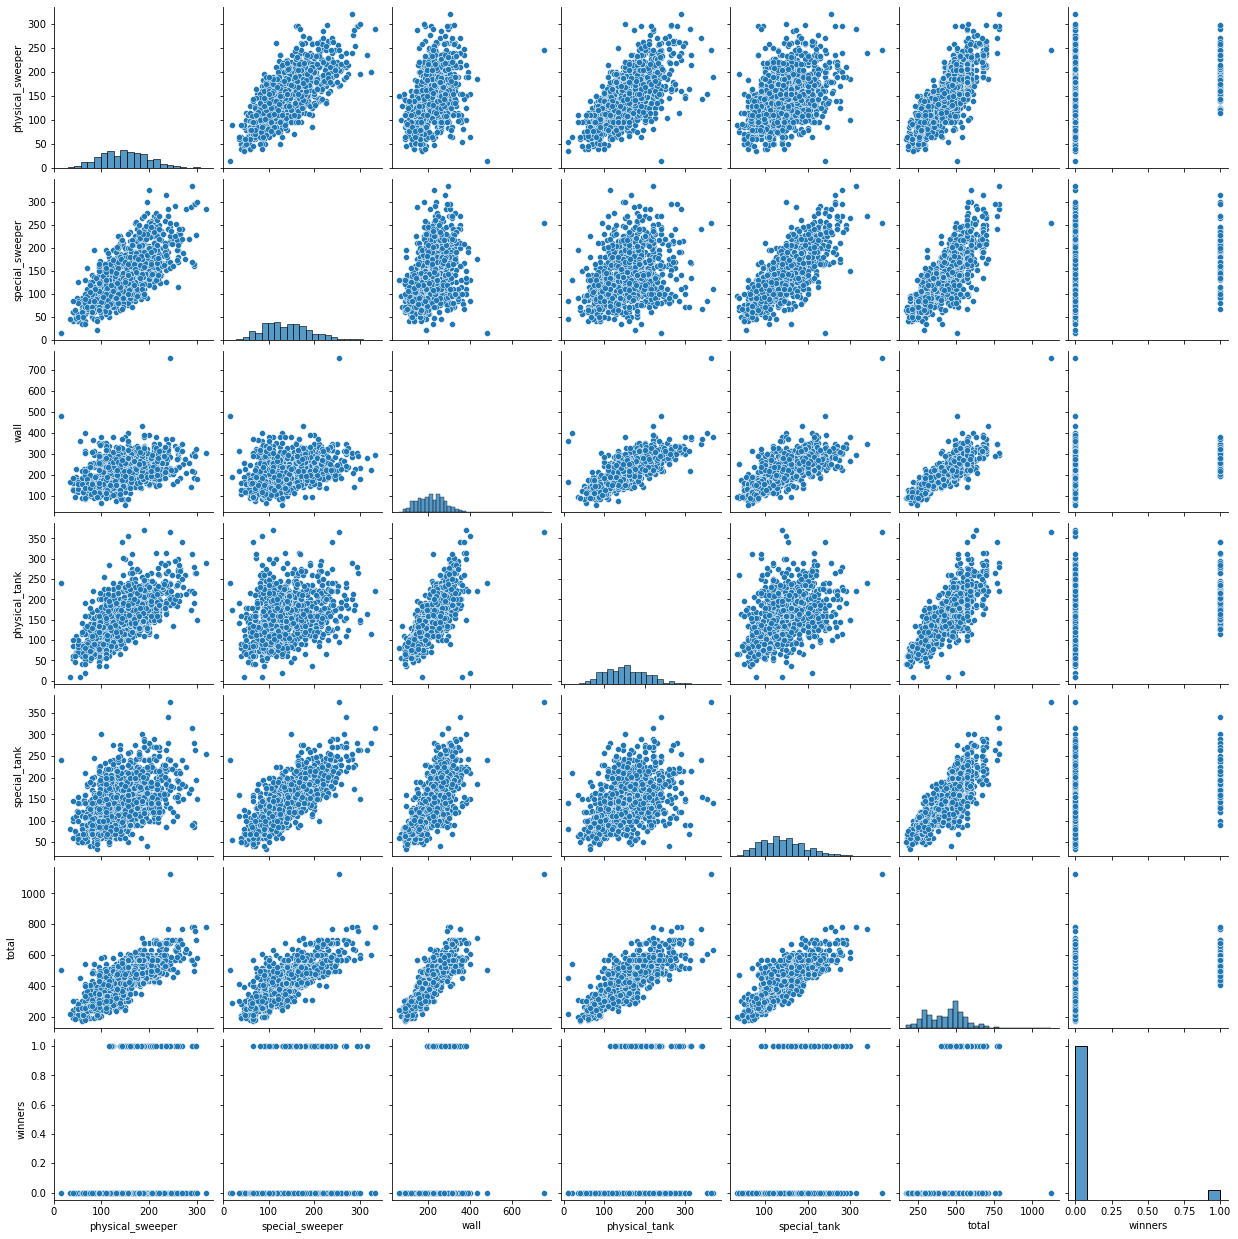

In [45]:
sns.pairplot(df);

There seems to be a lot of correlation between different stats with the exception of physical_tank with special_tank and physical_sweeper. This makes sense aeach of these are a combonation of various poke stats. However, we don't see a clear correlation with the winners column. Let's see if a heat map can shed some light on this.

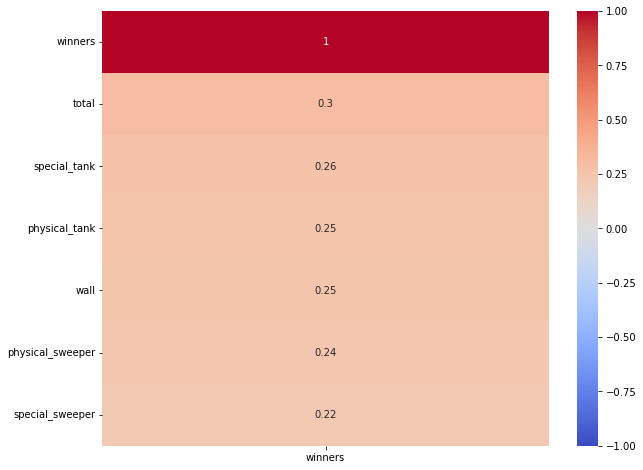

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr()[['winners']].sort_values(by='winners',ascending=False),
            annot = True,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm');

They are all roughly equal in correlation and none are particulary correlated. For the model we want to use the poketypes and moveset. Both need to be convered into text first

In [47]:
df.dtypes

names                object
physical_sweeper    float64
special_sweeper     float64
wall                float64
physical_tank       float64
special_tank        float64
total               float64
poke_types           object
form                 object
move_set             object
winners             float64
dtype: object

In [48]:
df['poke_types'] = df['poke_types'].map(lambda x: ' '.join(x))

In [49]:
df_dummies = pd.get_dummies(df, columns=['poke_types'], drop_first=False)
df_dummies.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
0,Bulbasaur,94.0,110.0,159.0,98.0,130.0,318.0,regular,"[[Venusaur], [Growl], [Tackle], [Vine Whip], [...",0.0,...,0,0,0,0,0,0,0,0,0,0
1,Ivysaur,122.0,140.0,203.0,125.0,160.0,405.0,regular,"[[Venusaur], [Growl], [Growth], [Tackle], [Vin...",0.0,...,0,0,0,0,0,0,0,0,0,0
2,Venusaur,162.0,180.0,263.0,165.0,200.0,525.0,regular,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",0.0,...,0,0,0,0,0,0,0,0,0,0
3,Venusaur,180.0,202.0,323.0,223.0,242.0,625.0,Mega Venusaur,"[[Venusaur], [Growl], [Growth], [Petal Blizzar...",0.0,...,0,0,0,0,0,0,0,0,0,0
4,Charmander,117.0,125.0,132.0,95.0,110.0,309.0,regular,"[[Charizard], [Growl], [Scratch], [Ember], [Sm...",0.0,...,0,0,0,0,0,0,0,0,0,0


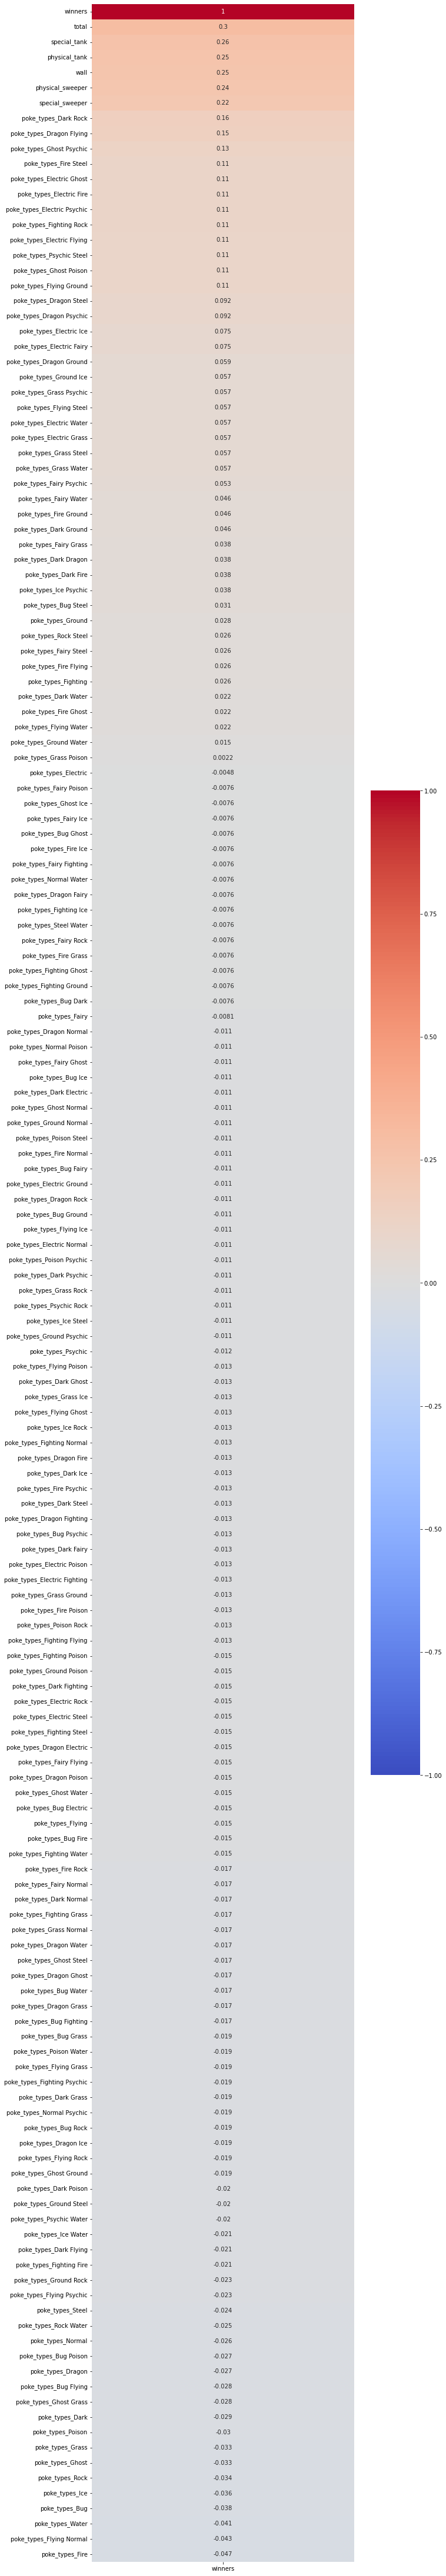

In [50]:
plt.figure(figsize=(10,80))
sns.heatmap(df_dummies.corr()[['winners']].sort_values(by='winners',ascending=False),
            annot = True,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm');

No type seems to correlate. I am going to attempt to make 2 models. The first will be a logistiv regression model based on the poke types and moves. Then I will try an nlp classification model based on the move sets to see if there are any trends based on moves. 

We need to split the data frame between the new games and the old ones. We need the pokemon named Sprigatito since it is the first in the Gen 9 pokedex

In [51]:
df[df['names'] == 'Sprigatito']

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types,form,move_set,winners
1079,Sprigatito,126.0,110.0,139.0,115.0,90.0,310.0,Grass,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0


In [52]:
df_old_gens = df_dummies[df_dummies.index < 1079]
df_old_gens.tail()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
1074,Basculegion,170.0,178.0,260.0,157.0,175.0,530.0,Sensu Style,"[[Basculegion], [Phantom Force], [Shadow Ball]...",0.0,...,0,0,0,0,0,0,0,0,0,0
1075,Sneasler,250.0,160.0,220.0,190.0,120.0,510.0,regular,"[[Sneasel], [Sneasler], [Fling], [Leer], [Rock...",0.0,...,0,0,0,0,0,0,0,0,0,0
1076,Overqwil,200.0,150.0,245.0,210.0,130.0,510.0,regular,"[[Overqwil], [Poison Sting], [Tackle], [Harden...",0.0,...,0,0,0,0,0,0,0,0,0,0
1077,Enamorus,221.0,241.0,224.0,185.0,215.0,580.0,regular,"[[Astonish], [Fairy Wind], [Torment], [Flatter...",0.0,...,0,0,0,0,0,0,0,0,0,0
1078,Enamorus,161.0,181.0,284.0,225.0,235.0,580.0,Own Tempo Rockruff,"[[Astonish], [Fairy Wind], [Torment], [Flatter...",0.0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df_gen9 = df_dummies[df_dummies.index >= 1079]
df_gen9.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
1079,Sprigatito,126.0,110.0,139.0,115.0,90.0,310.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0
1080,Floragato,163.0,143.0,187.0,143.0,123.0,410.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0
1081,Meowscarada,233.0,204.0,216.0,180.0,151.0,530.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0
1082,Fuecoco,81.0,99.0,166.0,104.0,103.0,310.0,regular,"[[Skeledirge], [Ember], [Leer], [Tackle], [Rou...",0.0,...,0,0,0,0,0,0,0,0,0,0
1083,Crocalor,104.0,139.0,217.0,133.0,148.0,411.0,regular,"[[Skeledirge], [Ember], [Leer], [Tackle], [Lic...",0.0,...,0,0,0,0,0,0,0,0,0,0


# Edit below here

Now we will make a training model on the old data and apply it to the Gen 9 data

In [54]:
#Training data
X8 = df_old_gens.drop(['names', 'form', 'move_set', 'winners'], axis=1)
#xvars = ['total', 'special_tank', ]
#X8 = df_old_gens[xvars]
X8.head()

,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types_Bug,poke_types_Bug Dark,poke_types_Bug Electric,poke_types_Bug Fairy,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
0,94.0,110.0,159.0,98.0,130.0,318.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,122.0,140.0,203.0,125.0,160.0,405.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,162.0,180.0,263.0,165.0,200.0,525.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,180.0,202.0,323.0,223.0,242.0,625.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,117.0,125.0,132.0,95.0,110.0,309.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#Training data
y8 = df_old_gens['winners']
y8.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: winners, dtype: float64

We will train and test split and make a model with the old poke generations. Then when we have a model we like we will apply it to the new poke generation to get our predictions

In [56]:
poly = PolynomialFeatures(include_bias = False, degree = 2)

In [57]:
X_poly = poly.fit_transform(X8)

In [58]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y8, random_state = 26)

In [59]:
#Logistic Regression
log_r = LogisticRegression()

In [60]:
log_r.fit(X_train, y_train)

C:\Users\matth\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
print(f'Training R2: {log_r.score(X_train, y_train)}')
print(f'Testing R2: {log_r.score(X_test, y_test)}')

Training R2: 0.9287531806615776
Testing R2: 0.9315589353612167


The logistic regression accounts for 93% of the variation in the data and isn't over or under fit. Overall it appears to be a good model in predicting which pokemon will do well competitively. So let us make our prediction using this model.

In [62]:
X9 = df_gen9.drop(['names', 'form', 'move_set', 'winners'], axis=1)
X9.head()

,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,poke_types_Bug,poke_types_Bug Dark,poke_types_Bug Electric,poke_types_Bug Fairy,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
1079,126.0,110.0,139.0,115.0,90.0,310.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080,163.0,143.0,187.0,143.0,123.0,410.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1081,233.0,204.0,216.0,180.0,151.0,530.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1082,81.0,99.0,166.0,104.0,103.0,310.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1083,104.0,139.0,217.0,133.0,148.0,411.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X9_poly = poly.fit_transform(X9)

In [64]:
prediction = log_r.predict(X9_poly)

In [65]:
df_gen9['prediction'] = prediction

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/2454306011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen9['prediction'] = prediction


In [66]:
df_gen9.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water,prediction
1079,Sprigatito,126.0,110.0,139.0,115.0,90.0,310.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1080,Floragato,163.0,143.0,187.0,143.0,123.0,410.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1081,Meowscarada,233.0,204.0,216.0,180.0,151.0,530.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1082,Fuecoco,81.0,99.0,166.0,104.0,103.0,310.0,regular,"[[Skeledirge], [Ember], [Leer], [Tackle], [Rou...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1083,Crocalor,104.0,139.0,217.0,133.0,148.0,411.0,regular,"[[Skeledirge], [Ember], [Leer], [Tackle], [Lic...",0.0,...,0,0,0,0,0,0,0,0,0,0.0


In [67]:
df_gen9.sort_values(by='prediction', axis=0, ascending=False)

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water,prediction
1079,Sprigatito,126.0,110.0,139.0,115.0,90.0,310.0,regular,"[[Meowscarada], [Leafage], [Scratch], [Tail Wh...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1149,Glimmora,141.0,216.0,254.0,145.0,211.0,525.0,regular,"[[Glimmora], [Harden], [Rock Throw], [Smack Do...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1160,Farigiraf,150.0,170.0,260.0,160.0,180.0,520.0,regular,"[[Farigiraf], [Astonish], [Growl], [Guard Swap...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1159,Clodsire,95.0,65.0,290.0,135.0,145.0,430.0,regular,"[[Wooper], [Clodsire], [Poison Sting], [Tail W...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
1158,Annihilape,205.0,140.0,280.0,195.0,140.0,535.0,regular,"[[Annihilape], [Counter], [Fling], [Focus Ener...",0.0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,Garganacl,135.0,80.0,320.0,230.0,135.0,500.0,regular,"[[Garganacl], [Block], [Harden], [Rock Blast],...",0.0,...,0,0,0,1,0,0,0,0,0,0.0
1111,Naclstack,95.0,70.0,225.0,160.0,100.0,355.0,regular,"[[Garganacl], [Harden], [Tackle], [Rock Throw]...",0.0,...,0,0,0,1,0,0,0,0,0,0.0
1110,Nacli,80.0,60.0,165.0,130.0,70.0,280.0,regular,"[[Garganacl], [Harden], [Tackle], [Rock Throw]...",0.0,...,0,0,0,1,0,0,0,0,0,0.0
1109,Squawkabilly,188.0,137.0,184.0,147.0,96.0,417.0,School Form,"[[Growl], [Mimic], [Peck], [Quick Attack], [To...",0.0,...,0,0,0,0,0,0,0,0,0,0.0


Based on this model, none of the new pokemon will be good competitevly. But perhaps we can look at probability of success rather than a binary

In [68]:
prediction = log_r.predict_proba(X9_poly)

In [69]:
df_gen9['prediction'] = prediction

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/2454306011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen9['prediction'] = prediction


In [70]:
df_gen9.sort_values(by='prediction', axis=0, ascending=False)

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water,prediction
1183,Chien-Pao,255.0,225.0,225.0,200.0,155.0,570.0,regular,"[[Mean Look], [Powder Snow], [Spite], [Icy Win...",0.0,...,0,0,0,0,0,0,0,0,0,0.998377
1164,Great Tusk,218.0,140.0,299.0,262.0,106.0,570.0,regular,"[[Defense Curl], [Horn Attack], [Rollout], [Su...",0.0,...,0,0,0,0,0,0,0,0,0,0.997577
1154,Cetitan,186.0,118.0,290.0,178.0,100.0,521.0,regular,"[[Cetitan], [Powder Snow], [Tackle], [Growl], ...",0.0,...,0,0,0,0,0,0,0,0,0,0.997281
1186,Roaring Moon,258.0,174.0,277.0,210.0,156.0,590.0,regular,"[[Bite], [Dragon Breath], [Focus Energy], [Lee...",0.0,...,0,0,0,0,0,0,0,0,0,0.996629
1139,Wugtrio,220.0,170.0,155.0,150.0,120.0,425.0,regular,"[[Wugtrio], [Mud-Slap], [Sand Attack], [Water ...",0.0,...,0,0,0,0,0,0,0,0,1,0.994965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,Scovillain,183.0,183.0,195.0,173.0,173.0,486.0,regular,"[[Scovillain], [Fire Fang], [Leafage], [Leer],...",0.0,...,0,0,0,0,0,0,0,0,0,0.644235
1150,Greavard,95.0,64.0,165.0,121.0,85.0,290.0,regular,"[[Houndstone], [Growl], [Tackle], [Lick], [Bit...",0.0,...,0,0,0,0,0,0,0,0,0,0.641467
1131,Rellor,80.0,61.0,159.0,110.0,89.0,270.0,regular,"[[Rabsca], [Defense Curl], [Tackle], [Sand Att...",0.0,...,0,0,0,0,0,0,0,0,0,0.636511
1113,Charcadet,85.0,85.0,120.0,90.0,90.0,255.0,regular,"[[Ceruledge], [Astonish], [Ember], [Leer], [Cl...",0.0,...,0,0,0,0,0,0,0,0,0,0.613697


Here we can see the probability that a pokemon wins a tournament. The top 5 contenders are Chien-Pao, Great Tusk, Cetitan, Roaring Moon, and Wugtrio. 2 of these are legendary pokemon (Chien-Pao and Roaring Moon) and 2 seem shockingly similar to older pokemon (Great Tusk with Donphan and Wugtrio with Dugtrio). All of these have a 99% chance of eventually winning a tournament.

The 5 worst pokemon of the new generation, based on the model, are Scovillian, Greavard, Rellor, Charcadet, and Tarountula. 4 of these 5 pokemon are the first stage of an evolutionary line. This is in line of what we can expect.

Now let's see if we can make a model based on the pokemons move set. We need our X and y values from the old gens to make our model from. To do this we first need to make the move set into a text document

In [71]:
testing_list = [['first'], ['second'], ['third'], ['fourth'], ['double word']]

In [72]:
def to_text(moves):
    word_list1 = []
    word_list2 = []
    for i in moves:
        word_list1.append(''.join(i))
    for j in word_list1:
        word_list2.append(j.replace(' ',''))
    return ' '.join(word_list2)

In [73]:
to_text(testing_list)

'first second third fourth doubleword'

In [74]:
df_old_gens['move_set'] = df_old_gens['move_set'].map(lambda x: to_text(x))

C:\Users\matth\AppData\Local\Temp/ipykernel_13132/392016591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_gens['move_set'] = df_old_gens['move_set'].map(lambda x: to_text(x))


In [75]:
df_old_gens.head()

,names,physical_sweeper,special_sweeper,wall,physical_tank,special_tank,total,form,move_set,winners,...,poke_types_Psychic,poke_types_Psychic Rock,poke_types_Psychic Steel,poke_types_Psychic Water,poke_types_Rock,poke_types_Rock Steel,poke_types_Rock Water,poke_types_Steel,poke_types_Steel Water,poke_types_Water
0,Bulbasaur,94.0,110.0,159.0,98.0,130.0,318.0,regular,Venusaur Growl Tackle VineWhip Growth LeechSee...,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Ivysaur,122.0,140.0,203.0,125.0,160.0,405.0,regular,Venusaur Growl Growth Tackle VineWhip LeechSee...,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Venusaur,162.0,180.0,263.0,165.0,200.0,525.0,regular,Venusaur Growl Growth PetalBlizzard PetalDance...,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Venusaur,180.0,202.0,323.0,223.0,242.0,625.0,Mega Venusaur,Venusaur Growl Growth PetalBlizzard PetalDance...,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Charmander,117.0,125.0,132.0,95.0,110.0,309.0,regular,Charizard Growl Scratch Ember Smokescreen Drag...,0.0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
X8 = df_old_gens['move_set']
y8 = df_old_gens['winners']

We need to make a baseline to see if our model will be a better predictor than just guessing

In [77]:
y8.value_counts(normalize=True)

0.0    0.931363
1.0    0.068637
Name: winners, dtype: float64

This means that about 6.9% of pokemon have won a tournament. Let's test out a few classification models

In [78]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state = 26)

In [79]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

In [80]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [81]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [82]:
# Transform the corpus.
X_train = cvec.transform(X_train)

In [83]:
X_train.shape

(786, 1079)

In [84]:
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [85]:
X_test = cvec.transform(X_test)

In [86]:
train_df = pd.DataFrame(X_train.todense(), columns = cvec.get_feature_names())

train_df.head()

,abomasnow,absorb,accelerock,acid,acidarmor,acidspray,acrobatics,acupressure,aegislash,aerialace,...,xatu,yamask,yanmega,yawn,zapcannon,zebstrika,zenheadbutt,zingzap,zoroark,zorua
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,3,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
train_df['moves'] = y_train.values

<AxesSubplot:>

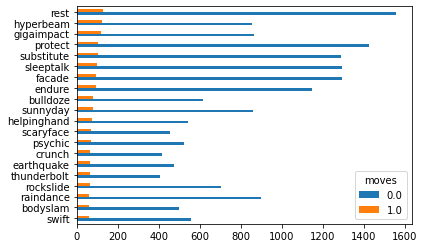

In [88]:
train_df.groupby('moves').sum().T.sort_values(1, ascending = True).tail(20).plot.barh()

This is the list of moves in order of if the winner pokemon can learn it. We see that rest is most common, followed by hyperbeam, gigaimpact, protect and substitute. Let's see if we can make a model with it.

In [89]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state = 26)

In [90]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [91]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [92]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.8753180661577609
Test: 0.8669201520912547


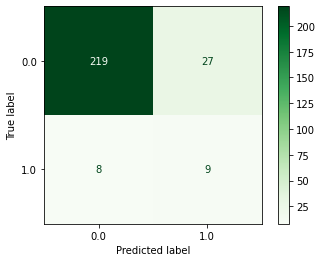

In [93]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens')

In [94]:
X9 = df_gen9['move_set']

Again, the model doesn't seem to find any winners

This can predict losers well but over guesses winners. Let's try a tiffy diff

In [95]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state = 26)

In [96]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [97]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

In [98]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.9300254452926209
Test: 0.935361216730038


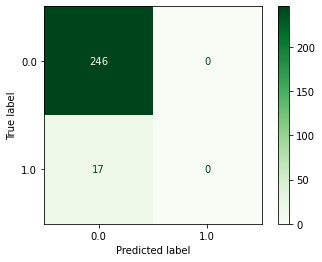

In [99]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens')

While the accounting of the variation is better the model didn't pick up any winners

In [100]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state = 26)

In [101]:
#take from https://stackoverflow.com/questions/40913104/how-to-use-randomforestclassifier-with-string-data
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
clf = RandomForestClassifier()  
clf.fit(X_train, y_train) 

RandomForestClassifier()

In [102]:
cross_val_score(clf, X_train, y_train, cv = 5).mean()

0.9605579295331775

We see that the random forest classifier gives a good model.

In [103]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state = 26)

In [104]:
#take from https://stackoverflow.com/questions/40913104/how-to-use-randomforestclassifier-with-string-data
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
et = ExtraTreesClassifier()  
et.fit(X_train, y_train) 

ExtraTreesClassifier()

In [105]:
cross_val_score(et, X_train, y_train, cv = 5).mean()

0.9516407320809483

We see that the extra trees classifier also gives a good model.

#### Conclusion: While we couldn't make a meaningful model based on the pokemon moves, we can based on the pokemons stats and types. We see that base stat total is the most important stat for determining a successful pokemon and that many of the new pokemon have a 99% chance of eventually winning an official tournament with Chien-Pao being considered the best pokemon of the new generation